# Sistem Rekomendasi Produk E-Commerce

Notebook ini membangun sistem rekomendasi menggunakan dua pendekatan:  
- **Content-Based Filtering (CBF)** berdasarkan deskripsi produk  
- **Collaborative Filtering (CF)** menggunakan interaksi user + produk  

Dataset diambil dari transaksi e-commerce UK, dengan total ~500.000 baris transaksi.

## Load Dataset

Dataset dimuat dari file CSV. Menggunakan encoding ISO-8859-1 karena format aslinya bukan UTF-8.

In [1]:
import pandas as pd

dataset_path = 'Dataset/data.csv'
df = pd.read_csv(dataset_path, encoding='ISO-8859-1')

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Pemeriksaan Awal Dataset

Pada tahap ini, dilakukan pemeriksaan awal terhadap struktur dan kualitas data yang digunakan, dengan menjalankan beberapa fungsi sebagai berikut:

- `df.shape`  
  Digunakan untuk melihat jumlah baris dan kolom dalam dataset.

- `df.isnull().sum()`  
  Untuk menghitung jumlah nilai kosong (missing values) pada setiap kolom.

- `df.duplicated().sum()`  
  Untuk mengecek jumlah baris duplikat dalam dataset.

- `df.describe()`  
  Menampilkan statistik deskriptif dari kolom numerik seperti:
  - Rata-rata (`mean`)
  - Standar deviasi (`std`)
  - Nilai minimum dan maksimum (`min`, `max`)
  - Kuartil (`25%`, `50%`, `75%`)

Tujuan dari langkah ini adalah untuk mengidentifikasi:
- Adanya **nilai kosong** yang perlu ditangani.
- Adanya **baris duplikat** yang perlu dihapus.
- Nilai-nilai **tidak valid** seperti `Quantity` atau `UnitPrice` yang ≤ 0.
- Rentang nilai untuk memastikan data masuk akal sebelum proses cleaning lebih lanjut.

In [2]:
print(f"Jumlah baris dan kolom: {df.shape}")
print(df.isnull().sum())
print(df.duplicated().sum())
df.describe()

Jumlah baris dan kolom: (541909, 8)
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
5268


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


**Jumlah Data:**
Dataset memiliki total 541.909 baris dan 8 kolom.

**Missing Value:**
Terdapat 1.454 baris dengan nilai kosong pada kolom Description.

Kolom CustomerID memiliki 135.080 baris kosong, yang berarti sekitar 25% data tidak memiliki informasi pelanggan dan perlu dibersihkan.

**Duplikasi:**
Dataset terdeteksi memiliki 5.268 baris duplikat.

| Kolom        | Temuan                                                                                                     |
| ------------ | ---------------------------------------------------------------------------------------------------------- |
| `Quantity`   | Terdapat nilai negatif hingga -80.995, menunjukkan kemungkinan retur atau error input.                     |
| `UnitPrice`  | Ada nilai negatif hingga -11.062, yang seharusnya tidak terjadi. Harga produk seharusnya bernilai positif. |
| `CustomerID` | Rentang ID pelanggan mulai dari 12346 hingga 18287. Tidak ada kejanggalan dari nilai minimum dan maksimum. |

## Data Cleaning

Tahap pembersihan dilakukan untuk memastikan data yang digunakan valid.  
Langkah-langkah cleaning mencakup:
- Menghapus transaksi retur (`InvoiceNo` diawali 'C')
- Menghapus produk dengan jumlah ≤ 0 atau harga ≤ 0
- Menghapus entri dengan `CustomerID` atau `Description` yang kosong

In [3]:
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

## Analisis Dasar Dataset

Setelah data dibersihkan, dilakukan perhitungan jumlah customer dan produk unik untuk memahami skala sistem rekomendasi yang akan dibuat.

In [4]:
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

### Menghapus Baris dengan Nilai Kosong

Kolom `CustomerID` dan `Description` merupakan atribut penting dalam membangun sistem rekomendasi.  
Karena itu, baris dengan nilai kosong pada kolom tersebut dihapus.

In [5]:
df = df.dropna(subset=['CustomerID', 'Description'])

### Statistik Dasar Dataset

Untuk memahami skala sistem rekomendasi, dilakukan perhitungan jumlah customer unik dan produk unik dalam dataset.  
Jumlah ini akan menentukan ukuran dan kompleksitas matrix pada pendekatan collaborative filtering.

In [6]:
num_customers = df['CustomerID'].nunique()
num_products = df['StockCode'].nunique()

print(f'Jumlah unique customer: {num_customers}')
print(f'Jumlah unique produk: {num_products}')

Jumlah unique customer: 4338
Jumlah unique produk: 3665


## Visualisasi Produk Terlaris

Visualisasi digunakan untuk mengetahui produk-produk yang paling sering dibeli oleh pelanggan.  
Langkah ini membantu memberikan insight tentang pola pembelian dan preferensi pelanggan dalam data.

Berikut adalah 10 produk dengan total kuantitas pembelian tertinggi:

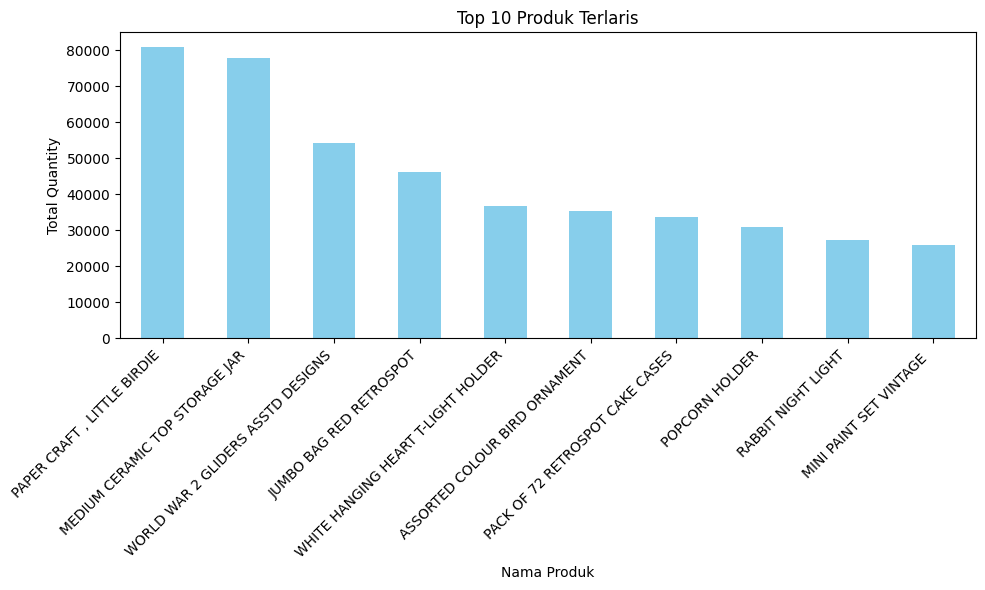

In [7]:
import matplotlib.pyplot as plt

top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_products.plot(kind='bar', color='skyblue')
plt.title('Top 10 Produk Terlaris')
plt.xlabel('Nama Produk')
plt.ylabel('Total Quantity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Terlihat bahwa produk seperti "PAPER CRAFT, LITTLE BIRDIE" dan "STORAGE JAR" memiliki volume penjualan paling tinggi dibandingkan produk lain.

## Negara dengan Jumlah Transaksi Terbanyak

Visualisasi berikut menunjukkan 10 negara dengan jumlah transaksi (Invoice unik) terbanyak dalam dataset.  
Informasi ini berguna untuk menentukan fokus sistem rekomendasi.

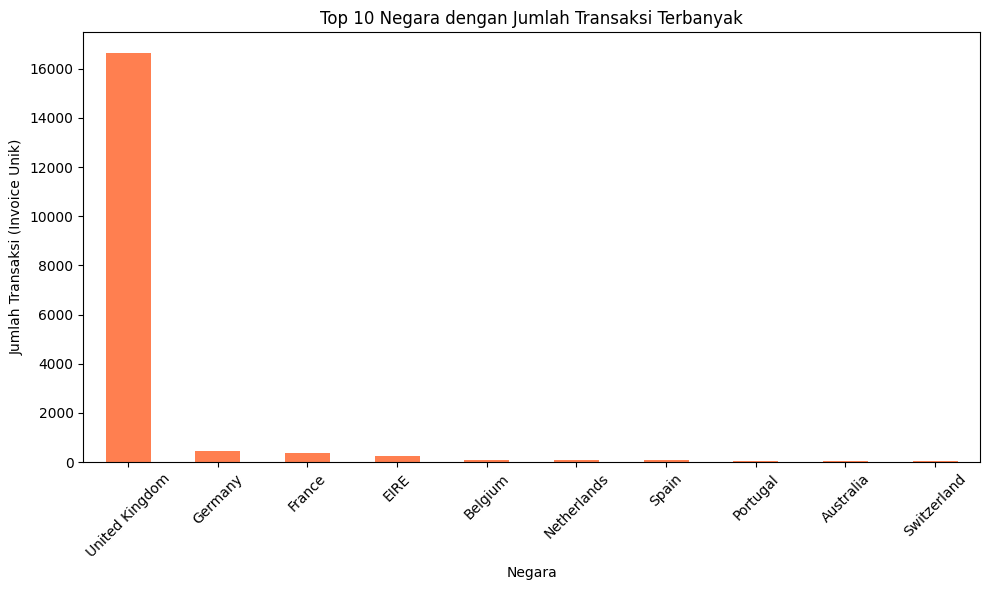

In [8]:
top_countries = df.groupby('Country')['InvoiceNo'].nunique().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_countries.plot(kind='bar', color='coral')
plt.title('Top 10 Negara dengan Jumlah Transaksi Terbanyak')
plt.xlabel('Negara')
plt.ylabel('Jumlah Transaksi (Invoice Unik)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Karena United Kingdom mendominasi jumlah transaksi secara signifikan, maka seluruh proses modeling akan difokuskan pada data dari UK saja untuk hasil yang lebih representatif dan stabil.

## Fokus pada Data United Kingdom

Berdasarkan analisis sebelumnya, sebagian besar transaksi berasal dari United Kingdom.  
Untuk menjaga konsistensi dan mengurangi bias global, maka seluruh proses sistem rekomendasi hanya menggunakan data dari UK.

In [9]:
df = df[df['Country'] == 'United Kingdom']

## Content-Based Filtering (CBF)

CBF menggunakan informasi deskriptif dari produk untuk mencari kemiripan antar item.  
Langkah pertama adalah mentransformasi kolom `Description` menjadi representasi numerik menggunakan TF-IDF (Term Frequency - Inverse Document Frequency).  
Setiap produk diubah menjadi vektor berbasis kata unik dalam deskripsinya.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')

product_df = df[['StockCode', 'Description']].drop_duplicates()

tfidf_matrix = tfidf.fit_transform(product_df['Description'])

print(f'Shape TF-IDF Matrix: {tfidf_matrix.shape}')

Shape TF-IDF Matrix: (3864, 1967)


### Menghitung Similaritas antar Produk

Setelah mendapatkan vektor TF-IDF, kita menghitung kemiripan antar produk menggunakan **cosine similarity**.  
Nilai similarity disimpan dalam bentuk matrix 2D dengan ukuran (produk × produk).

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

print(f'Shape Cosine Similarity Matrix: {cosine_sim.shape}')

Shape Cosine Similarity Matrix: (3864, 3864)


### Fungsi Rekomendasi Produk Berdasarkan Deskripsi

Fungsi ini menerima input berupa nama produk (`Description`), lalu mengembalikan daftar produk lain yang paling mirip berdasarkan nilai cosine similarity.  
Mirip di sini artinya memiliki konteks kata dan deskripsi yang relevan secara semantik.

In [12]:
indices = pd.Series(product_df.index, index=product_df['Description'])

def recommend_product(description, top_n=5):
    if description not in indices:
        return f'Produk "{description}" tidak ditemukan.'

    idx = indices[description]

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    top_indices = [i[0] for i in sim_scores[1:top_n+1]]

    return product_df.iloc[top_indices][['StockCode', 'Description']]

### Contoh Rekomendasi Produk

Berikut adalah hasil rekomendasi dari sistem Content-Based Filtering ketika diberikan input produk:

> **"RED WOOLLY HOTTIE WHITE HEART."**

Sistem mengembalikan 5 produk dengan deskripsi paling mirip berdasarkan TF-IDF dan cosine similarity:

In [13]:
recommend_product('RED WOOLLY HOTTIE WHITE HEART.')

,StockCode,Description
73996,90123D,WHITE HEART OF GLASS BRACELET
220483,23321,SMALL WHITE HEART OF WICKER
327553,23412,HEART MIRROR ANTIQUE WHITE
223179,23322,LARGE WHITE HEART OF WICKER
42364,16206B,RED PURSE WITH PINK HEART


- Produk dengan elemen kata "HEART", "WHITE", "WICKER", atau "BRACELET" muncul sebagai hasil utama.
- Hal ini menunjukkan bahwa sistem dapat mengenali korelasi semantik antar deskripsi produk.

## Evaluasi Model Content-Based Filtering

Evaluasi dilakukan untuk mengetahui seberapa relevan hasil rekomendasi dari CBF terhadap produk-produk yang juga pernah dibeli oleh user.

Langkah evaluasi:
1. Ambil satu produk dari user sebagai input sistem rekomendasi.
2. Gunakan `recommend_product()` untuk mendapatkan produk mirip.
3. Produk lain yang pernah dibeli user dibandingkan dengan hasil rekomendasi sebagai ground truth.

In [14]:
import numpy as np

def precision_at_k(recommended, relevant, k):
    recommended_at_k = recommended[:k]
    relevant_set = set(relevant)
    return len([item for item in recommended_at_k if item in relevant_set]) / k

def recall_at_k(recommended, relevant, k):
    recommended_at_k = recommended[:k]
    relevant_set = set(relevant)
    return len([item for item in recommended_at_k if item in relevant_set]) / len(relevant_set) if relevant_set else 0

def f1_score_at_k(precision, recall):
    return 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

def average_precision(recommended, relevant, k):
    relevant_set = set(relevant)
    score = 0.0
    hits = 0
    for i in range(k):
        if recommended[i] in relevant_set:
            hits += 1
            score += hits / (i + 1)
    return score / min(len(relevant_set), k) if relevant_set else 0

def ndcg_at_k(recommended, relevant, k):
    dcg = 0.0
    for i in range(k):
        if recommended[i] in relevant:
            dcg += 1 / np.log2(i + 2)
    idcg = sum([1 / np.log2(i + 2) for i in range(min(len(relevant), k))])
    return dcg / idcg if idcg > 0 else 0

Metrik evaluasi yang digunakan:
- **Precision@K**: Persentase item relevan dari total top-K rekomendasi.
- **Recall@K**: Seberapa banyak item relevan yang berhasil ditangkap.
- **F1@K**: Harmonik dari precision dan recall.
- **MAP@K**: Rata-rata presisi kumulatif.
- **NDCG@K**: Mengukur relevansi sekaligus mempertimbangkan urutan hasil.

Hasil evaluasi akan tergantung pada seberapa mirip deskripsi produk dan keterkaitan pembelian user.

In [15]:
def evaluate_cbf_for_user(user_id, top_k=5):
    if user_id not in df['CustomerID'].values:
        return f"User {user_id} tidak ditemukan."

    user_items = df[df['CustomerID'] == user_id]['Description'].unique()

    if len(user_items) < 2:
        return f"User {user_id} tidak cukup interaksi untuk evaluasi."

    target_desc = user_items[0]
    ground_truth = set(user_items[1:])

    recs = recommend_product(target_desc, top_k)
    recommended = recs['Description'].tolist()

    precision = precision_at_k(recommended, ground_truth, top_k)
    recall = recall_at_k(recommended, ground_truth, top_k)
    f1 = f1_score_at_k(precision, recall)
    map_score = average_precision(recommended, ground_truth, top_k)
    ndcg = ndcg_at_k(recommended, ground_truth, top_k)

    return {
        'Precision@K': round(precision, 4),
        'Recall@K': round(recall, 4),
        'F1@K': round(f1, 4),
        'MAP@K': round(map_score, 4),
        'NDCG@K': round(ndcg, 4)
    }

### Hasil Evaluasi

Evaluasi dilakukan untuk user `12748.0` dengan `top_k = 5` menghasilkan:

- Precision@5 = 0.4
- Recall@5 = 0.0011
- F1@5 = 0.0022
- MAP@5 = 0.3333
- NDCG@5 = 0.5087

Hasil ini menunjukkan bahwa sebagian rekomendasi berhasil relevan dengan riwayat pembelian user (precision tinggi), namun recall rendah karena ground truth-nya cukup banyak dan sistem hanya merekomendasikan 5 produk saja.

In [16]:
evaluate_cbf_for_user(12748.0, top_k=5)

{'Precision@K': 0.4,
 'Recall@K': 0.0011,
 'F1@K': 0.0022,
 'MAP@K': 0.3333,
 'NDCG@K': np.float64(0.5087)}

# Visualisasi Cosine Similarity antar Produk
Untuk melihat bagaimana sistem mengenali kemiripan antar produk berdasarkan deskripsi,  
dihitung cosine similarity dari TF-IDF deskripsi produk, dan divisualisasikan dalam bentuk heatmap.

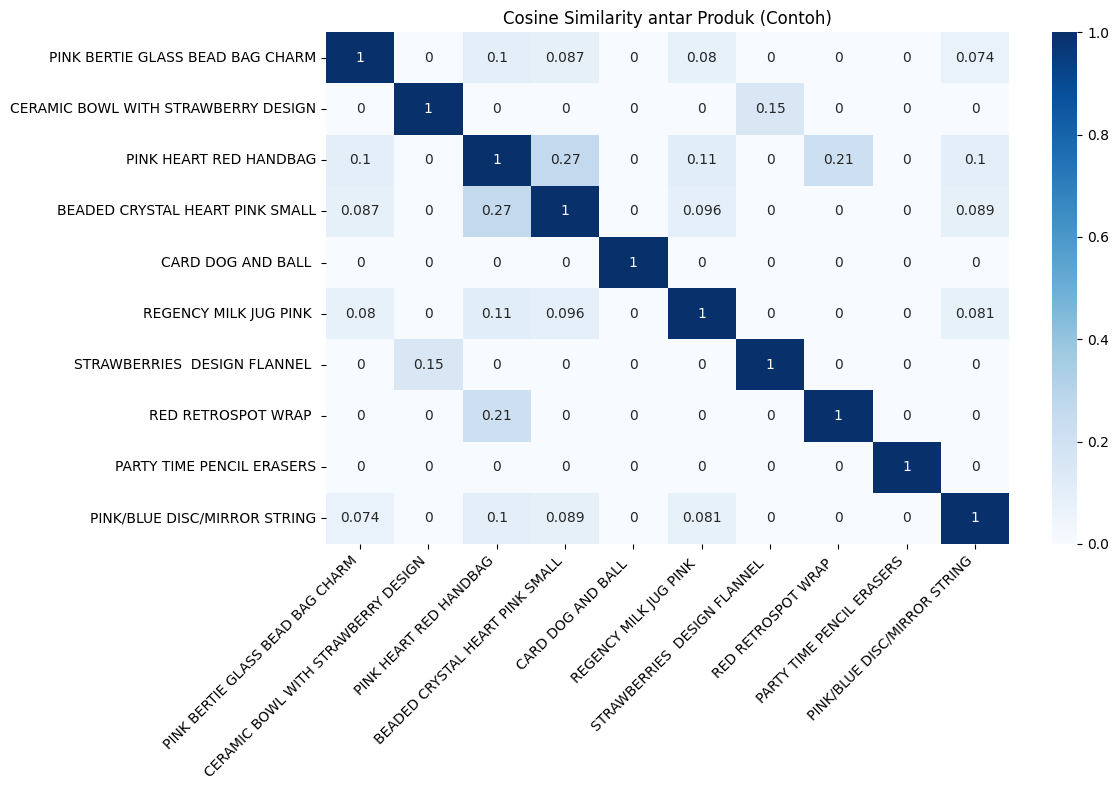

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

sample_indices = product_df.sample(10, random_state=42).index.to_list()
position_indices = list(product_df.index.get_indexer(sample_indices))

sample_sim = cosine_sim[position_indices][:, position_indices]

labels = product_df.iloc[position_indices]['Description']

plt.figure(figsize=(12, 8))
sns.heatmap(sample_sim, xticklabels=labels, yticklabels=labels, annot=True, cmap='Blues')
plt.title('Cosine Similarity antar Produk (Contoh)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Semakin gelap warna biru, semakin tinggi nilai similarity-nya. Visualisasi ini menunjukkan bahwa sistem Content-Based Filtering berhasil menemukan pola semantik antar produk.

## Collaborative Filtering (CF)

Pendekatan Collaborative Filtering dilakukan dengan membangun matrix interaksi `CustomerID x StockCode` menggunakan jumlah pembelian (`Quantity`) sebagai nilai interaksi.

Matrix ini menjadi dasar untuk mengenali pola kesamaan antar pengguna berdasarkan produk yang mereka beli.

In [18]:
user_product_matrix = df.pivot_table(
    index='CustomerID',
    columns='StockCode',
    values='Quantity',
    aggfunc='sum',
    fill_value=0
)

user_product_matrix.head()

StockCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214V,90214W,90214Y,90214Z,BANK CHARGES,C2,DOT,M,PADS,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12747.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12748.0,1,0,6,0,0,0,0,28,36,32,...,0,0,0,0,0,0,0,235,0,1
12749.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
12820.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Model CF menggunakan K-Nearest Neighbors (KNN)

Model KNN digunakan untuk mencari user yang memiliki pola pembelian serupa (tetangga terdekat) menggunakan cosine similarity sebagai metrik kemiripan antar user.

Algoritma `brute` dipilih karena dataset relatif kecil sehingga performanya masih efisien.

In [19]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

user_item_matrix = user_product_matrix.values

model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(user_item_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

### Fungsi Rekomendasi Berdasarkan CF

Terdapat dua fungsi utama:
1. `recommend_by_user()`  
   Mengembalikan daftar tetangga (user yang mirip) berdasarkan interaksi.

In [20]:
def recommend_by_user(user_id, n_neighbors=5):
    if user_id not in user_product_matrix.index:
        return f'CustomerID {user_id} tidak ditemukan.'

    user_index = list(user_product_matrix.index).index(user_id)
    distances, indices = model_knn.kneighbors(
        [user_item_matrix[user_index]],
        n_neighbors=n_neighbors + 1
    )

    neighbor_ids = [user_product_matrix.index[i] for i in indices.flatten() if user_product_matrix.index[i] != user_id]
    return neighbor_ids

2. `recommend_products_for_user()`  
   Mengembalikan daftar produk yang dibeli oleh user tetangga tapi belum dibeli oleh user target.  
   Hasil produk dirangking berdasarkan total pembelian user tetangga.

In [21]:
def recommend_products_for_user(user_id, n_neighbors=5, top_n=5):
    if user_id not in user_product_matrix.index:
        return f'CustomerID {user_id} tidak ditemukan.'

    user_index = list(user_product_matrix.index).index(user_id)
    distances, indices = model_knn.kneighbors(
        [user_item_matrix[user_index]],
        n_neighbors=n_neighbors + 1
    )

    neighbor_indices = indices.flatten()[1:]
    neighbor_ids = [user_product_matrix.index[i] for i in neighbor_indices]

    neighbor_data = user_product_matrix.loc[neighbor_ids]
    summed_products = neighbor_data.sum().sort_values(ascending=False)

    user_products = user_product_matrix.loc[user_id]
    already_bought = user_products[user_products > 0].index
    recommended = summed_products[~summed_products.index.isin(already_bought)]

    result = pd.DataFrame(recommended.head(top_n)).reset_index()
    result.columns = ['StockCode', 'Score']
    result = result.merge(product_df, on='StockCode', how='left').drop_duplicates('StockCode')

    return result[['StockCode', 'Description', 'Score']]

### Contoh Rekomendasi Produk oleh Collaborative Filtering

Berikut adalah contoh hasil rekomendasi untuk user dengan ID `12748.0`.

Sistem CF mengidentifikasi produk-produk yang belum dibeli user, namun sering dibeli oleh user lain yang memiliki pola interaksi serupa.

Hasil rekomendasi ditampilkan berdasarkan skor kemunculan produk di tetangga terdekat.

In [22]:
recommend_products_for_user(12748.0)

,StockCode,Description,Score
0,84947,ANTIQUE SILVER TEA GLASS ENGRAVED,72
1,22422,TOOTHPASTE TUBE PEN,58
2,16048,TEATIME ROUND PENCIL SHARPENER,48
3,22043,CHRISTMAS CARD SCREEN PRINT,48
4,82483,WOOD 2 DRAWER CABINET WHITE FINISH,37


## Metrik Evaluasi

Berikut adalah implementasi metrik evaluasi yang digunakan untuk menilai performa model rekomendasi:

- **Precision@K**: Mengukur proporsi item relevan dalam top-K rekomendasi.
- **Recall@K**: Mengukur seberapa banyak item relevan yang berhasil ditangkap dari semua item relevan.
- **F1-Score@K**: Rata-rata harmonik antara precision dan recall.
- **MAP@K (Mean Average Precision)**: Rata-rata presisi posisi relevan di seluruh top-K.
- **NDCG@K (Normalized Discounted Cumulative Gain)**: Mengukur relevansi dan memperhitungkan posisi item dalam daftar rekomendasi.

In [23]:
def precision_at_k(recommended, relevant, k):
    recommended_at_k = recommended[:k]
    relevant_set = set(relevant)
    return len([item for item in recommended_at_k if item in relevant_set]) / k

def recall_at_k(recommended, relevant, k):
    recommended_at_k = recommended[:k]
    relevant_set = set(relevant)
    return len([item for item in recommended_at_k if item in relevant_set]) / len(relevant_set) if relevant_set else 0

def f1_score_at_k(precision, recall):
    return 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

def average_precision(recommended, relevant, k):
    relevant_set = set(relevant)
    score = 0.0
    hits = 0
    for i in range(k):
        if i < len(recommended) and recommended[i] in relevant_set:
            hits += 1
            score += hits / (i + 1)
    return score / min(len(relevant_set), k) if relevant_set else 0

def ndcg_at_k(recommended, relevant, k):
    dcg = 0.0
    for i in range(k):
        if i < len(recommended) and recommended[i] in relevant:
            dcg += 1 / np.log2(i + 2)
    idcg = sum([1 / np.log2(i + 2) for i in range(min(len(relevant), k))])
    return dcg / idcg if idcg > 0 else 0

## Evaluasi Model Collaborative Filtering

Evaluasi dilakukan dengan cara:
1. Ambil seluruh riwayat pembelian user.
2. Simulasikan sebagian produk "tidak diketahui".
3. Gunakan sisanya sebagai input untuk merekomendasikan produk baru.
4. Bandingkan hasil rekomendasi dengan produk relevan (ground truth).

Evaluasi dilakukan menggunakan 5 metrik utama:
- **Precision@K**
- **Recall@K**
- **F1@K**
- **MAP@K**
- **NDCG@K**

Semua metrik mengukur seberapa relevan dan akurat hasil sistem rekomendasi dalam top-K produk.

In [24]:
def evaluate_user(user_id, top_k=5, return_debug=False):
    if user_id not in user_product_matrix.index:
        return f"User {user_id} tidak ditemukan."

    user_data = user_product_matrix.loc[user_id]
    bought = list(user_data[user_data > 0].index)

    if len(bought) < 2:
        return f"User {user_id} tidak punya cukup produk untuk evaluasi."

    split = len(bought) // 2
    known_items = bought[:split]
    ground_truth = bought[split:]

    simulated_user_vector = user_data.copy()
    simulated_user_vector[ground_truth] = 0

    simulated_matrix = user_product_matrix.copy()
    simulated_matrix.loc[user_id] = simulated_user_vector
    model_knn.fit(simulated_matrix.values)

    rec_df = recommend_products_for_user(user_id, top_n=top_k)
    recommended = rec_df['StockCode'].astype(str).tolist() if isinstance(rec_df, pd.DataFrame) else []

    precision = precision_at_k(recommended, ground_truth, top_k)
    recall = recall_at_k(recommended, ground_truth, top_k)
    f1 = f1_score_at_k(precision, recall)
    map_score = average_precision(recommended, ground_truth, top_k)
    ndcg = ndcg_at_k(recommended, ground_truth, top_k)

    result = {
        'Precision@K': round(precision, 4),
        'Recall@K': round(recall, 4),
        'F1@K': round(f1, 4),
        'MAP@K': round(map_score, 4),
        'NDCG@K': round(ndcg, 4)
    }

    if return_debug:
        return result, ground_truth, recommended
    else:
        return result

### Hasil Evaluasi Collaborative Filtering

Evaluasi untuk user `12748.0` dengan `top_k = 20` menghasilkan metrik berikut:

- Precision@20 = 0.0
- Recall@20 = 0.0
- F1@20 = 0.0
- MAP@20 = 0.0
- NDCG@20 = 0.0

In [25]:
result, ground_truth, recommended = evaluate_user(12748.0, top_k=20, return_debug=True)

print("Ground truth:", ground_truth)
print("Rekomendasi :", recommended)
print("Metrik Eval :", result)

Ground truth: ['22635', '22636', '22637', '22644', '22645', '22646', '22647', '22653', '22654', '22659', '22661', '22662', '22663', '22665', '22666', '22667', '22668', '22669', '22670', '22672', '22674', '22675', '22678', '22681', '22683', '22686', '22689', '22691', '22693', '22694', '22695', '22697', '22698', '22699', '22701', '22702', '22703', '22704', '22705', '22707', '22708', '22710', '22711', '22712', '22713', '22714', '22717', '22720', '22721', '22722', '22723', '22725', '22726', '22727', '22728', '22729', '22730', '22731', '22732', '22733', '22734', '22735', '22736', '22737', '22738', '22739', '22741', '22742', '22743', '22744', '22745', '22746', '22747', '22748', '22749', '22750', '22751', '22752', '22753', '22754', '22755', '22756', '22757', '22758', '22760', '22766', '22767', '22768', '22771', '22774', '22775', '22776', '22778', '22780', '22781', '22782', '22785', '22786', '22791', '22794', '22796', '22797', '22798', '22800', '22804', '22807', '22809', '22810', '22812', '228

### Analisis:

Hasil evaluasi model Collaborative Filtering menunjukkan nilai nol pada seluruh metrik.  
Hal ini disebabkan oleh **tidaknya ada overlap** antara produk yang direkomendasikan dan produk yang sebelumnya dibeli oleh user (ground truth).  
Beberapa kemungkinan penyebab:
- User `12748.0` merupakan **outlier** dengan jumlah interaksi sangat tinggi.
- Produk yang dibeli tergolong **unik/niche**, tidak cukup umum untuk ditemukan oleh user lain.
- Matrix user-item memiliki **sparsity tinggi**, menyebabkan sulitnya menemukan tetangga relevan.

Meskipun demikian, proses evaluasi tetap dilakukan dan hasil ditampilkan secara transparan untuk menunjukkan keterbatasan CF pada kondisi tertentu.

# Perbandingan Metrik Evaluasi: CBF vs CF
Grafik berikut menunjukkan perbandingan nilai evaluasi dari kedua pendekatan sistem rekomendasi:
- **CBF (Content-Based Filtering)**
- **CF (Collaborative Filtering)**

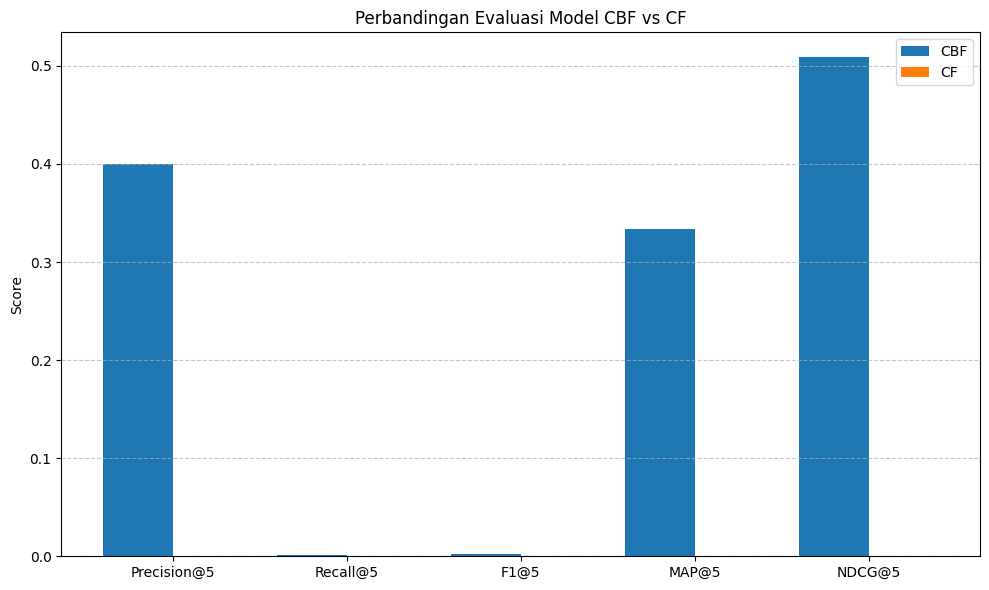

In [26]:
import matplotlib.pyplot as plt

metrics = ['Precision@5', 'Recall@5', 'F1@5', 'MAP@5', 'NDCG@5']
cbf_scores = [0.4, 0.0011, 0.0022, 0.3333, 0.5087]
cf_scores = [0.0, 0.0, 0.0, 0.0, 0.0]

x = range(len(metrics))

plt.figure(figsize=(10, 6))
plt.bar(x, cbf_scores, width=0.4, label='CBF', align='center')
plt.bar([i + 0.4 for i in x], cf_scores, width=0.4, label='CF', align='center')

plt.xticks([i + 0.2 for i in x], metrics)
plt.ylabel('Score')
plt.title('Perbandingan Evaluasi Model CBF vs CF')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

CBF menghasilkan skor yang jauh lebih baik dibanding CF, terutama pada Precision, MAP, dan NDCG. Hal ini menunjukkan bahwa dalam konteks dataset ini, pendekatan berbasis konten lebih cocok digunakan.